<a href="https://colab.research.google.com/github/cmentus/Generative-model-workbook/blob/main/WGANGP_5pm_10-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model,layers, regularizers

import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt

# Constructing GAN
## Define loss
* Wasserstein loss
* JS divergence

In [ ]:
generator_encoded=keras.models.load_model("drive/MyDrive/GAN/generator_encoded_epoch300")
discriminator=keras.models.load_model("drive/MyDrive/GAN/discriminator_epoch300")

In [ ]:
wasserstein=True
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
if wasserstein==False:

else:

## Generator

In [3]:
#generator is our generator model
def make_generator(n_output, n_input = 100, hidden_widths = [128,128,128],minibatch_avg=True,output_activation = tf.keras.activations.linear):
    ''' Make generator for data of data_dim number of fields. The input_dim represents the noise but could be used for style transfer.
    gen_hidden_widths are the widths of the hidden layers of the nn'''
    gen_input_layer = layers.Input(shape=(n_input,),name="GeneratorInput")
    gen_input_batch_norm=layers.BatchNormalization(name="GenBNInput")(gen_input_layer)


    gen_hidden_layers=[layers.Dense(units=hidden_widths[0],activation=tf.nn.relu,name="GenHiddenLayer0")(gen_input_batch_norm)]

    for i in range(1,len(hidden_widths)):
        gen_hidden_layers=gen_hidden_layers+[layers.BatchNormalization(name="GenBNLayer"+str(i))(gen_hidden_layers[-1])]
        gen_hidden_layers=gen_hidden_layers+[layers.Dense(units=hidden_widths[i],activation=tf.nn.leaky_relu,
                                                          name="GenHiddenLayer"+str(i))(gen_hidden_layers[-1])]
        gen_hidden_layers=gen_hidden_layers+\
        [layers.Add(name="GenSkipLayer"+str(i))((gen_hidden_layers[-1],gen_hidden_layers[-3]))]


    gen_output=layers.Dense(units=n_output,activation=output_activation,
                                                          name="GenOutput")(gen_hidden_layers[-1])
    if(minibatch_avg):
        gen_output_avg=tf.reduce_mean(gen_output,axis=0,keepdims=True,name="GenOutputAverage")*\
        tf.ones(shape=tf.shape(gen_output))

        generator=tf.keras.Model(
            inputs=[gen_input_layer],
            outputs=[gen_output,gen_output_avg],
        )
        return generator
    else:
        generator=tf.keras.Model(
            inputs=[gen_input_layer],
            outputs=[gen_output],
        )
        return generator

In [ ]:
generator = make_generator(n_output = 1,n_input = 100, hidden_widths=[128])
tf.keras.utils.plot_model(generator, "images/generator_test_minibatch.png")
generator1 = make_generator(n_output = 1,n_input = 100, hidden_widths=[128],minibatch_avg=False)
tf.keras.utils.plot_model(generator1, "images/generator_test.png")

FileNotFoundError: ignored

## Discriminator

In [5]:
disc_hidden_widths=[128,256,256]
def make_discriminator(n_input, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True):
    if minibatch_avg:
        disc_input_layer=layers.Input(shape=(n_input,),name="DiscriminatorInput")
        disc_avg_input_layer=layers.Input(shape=(n_input,),name="DiscriminatorAverageInput")
        disc_allinput=layers.Concatenate(name="DiscriminatorAllInput")((disc_input_layer,
                                                                                    disc_avg_input_layer,
                                                                                   ))
    else:
        disc_allinput=layers.Input(shape=(n_input,),name="DiscriminatorAllInput")
    
    disc_hidden_layers=[layers.Dense(units=disc_hidden_widths[0],activation=tf.nn.leaky_relu,name="DiscHiddenLayer0")(disc_allinput)]

    for i in range(1,len(disc_hidden_widths)):
        disc_hidden_layers=disc_hidden_layers+\
        [layers.Dense(units=disc_hidden_widths[i],activation=tf.nn.leaky_relu,name="DiscHiddenLayer"+str(i))(disc_hidden_layers[-1])]
    if gan_type=="JS":
        disc_output=layers.Dense(units=1,activation=tf.nn.sigmoid,name="DiscriminatorOutput")(disc_hidden_layers[-1])
    if gan_type=="W":
        disc_output=layers.Dense(units=1,activation=tf.keras.activations.linear,name="DiscriminatorOutput")(disc_hidden_layers[-1])
    
    if minibatch_avg:
        discriminator=tf.keras.Model(
            inputs=[disc_input_layer,disc_avg_input_layer],
            outputs=[disc_output]
        )
        return discriminator
    else:
        discriminator=tf.keras.Model(
            inputs=disc_allinput,
            outputs=[disc_output]
        )
        return discriminator

In [ ]:
discriminator = make_discriminator(n_input=10, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True)
tf.keras.utils.plot_model(discriminator, "images/discriminator_test_minibatch.png")
discriminator1 = make_discriminator(n_input=10, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=False)
tf.keras.utils.plot_model(discriminator1, "images/discriminator_test.png")

FileNotFoundError: ignored

# Discriminator and Generator Losses

In [6]:
def w_discriminator_loss(real_output,fake_output):
    real_loss = -tf.reduce_mean(real_output)    #
    fake_loss = tf.reduce_mean(fake_output) #smaller 
    total_loss = real_loss + fake_loss
    return total_loss
def w_generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)
w_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)
w_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)

In [7]:
#gradient penalty
def discriminator_gradient_penalty_ma(real_output,fake_output,discriminator):
    batch_shape=tf.shape(real_output[0])
    uniform_rand = tf.random.uniform(shape=batch_shape, maxval=1)
    mask_fake = uniform_rand #tf.math.greater(.5, uniform_rand)
    mask_fake = tf.cast(mask_fake,"float32")
    mask_real = (1.-mask_fake)
    mixed_real_fake = (mask_fake*fake_output[0] + mask_real*real_output[0],\
                               mask_fake*fake_output[1] + mask_real*real_output[1])
    with tf.GradientTape() as g:
        g.watch(mixed_real_fake)
        y = discriminator(mixed_real_fake)
    disc_gradient = g.gradient(y, mixed_real_fake)
    gradient_penalty = tf.reduce_mean(tf.square(
        tf.sqrt(tf.reduce_sum(tf.square(tf.concat(disc_gradient,axis=1)),axis=1))\
        - tf.ones(shape=(batch_shape[0],1))))
    return gradient_penalty


def discriminator_gradient_penalty(real_output,fake_output,discriminator):
    batch_shape=tf.shape(real_output)
    uniform_rand = tf.random.uniform(shape=batch_shape, maxval=1)
    mask_fake = uniform_rand #tf.math.greater(.5, uniform_rand)
    mask_fake = tf.cast(mask_fake,"float32")
    mask_real = (1.-mask_fake)
    mixed_real_fake = (mask_fake*fake_output[0] + mask_real*real_output,\
                               mask_fake*fake_output[1] + mask_real*real_output)
    with tf.GradientTape() as g:
        g.watch(mixed_real_fake)
        y = discriminator(mixed_real_fake)
    disc_gradient = g.gradient(y, mixed_real_fake)
    gradient_penalty = tf.reduce_mean(tf.square(
        tf.sqrt(tf.reduce_sum(tf.square(tf.concat(disc_gradient,axis=1)),axis=1))\
        - tf.ones(shape=(batch_shape[0],1))))
    return gradient_penalty

In [ ]:

discriminator((tf.random.normal((1,10)),tf.random.normal((1,10))))
discriminator_gradient_penalty((tf.random.normal((1,10)),tf.random.normal((1,10))),
                               (tf.random.normal((1,10)),tf.random.normal((1,10))),discriminator)


ValueError: ignored

# Training loop for Generator Discriminator pair

In [8]:
# This is meant to be a very general training step for systems of GAN
def train_step(generators, #dictionary string -> generator
               discriminators, #dictionary string -> discriminator
               real_data, #dictionary string for discriminator -> real data
               gen_objective, #dictionary string -> objective function
               disc_objective,
               gen_input,
               gen_optimizers,
               disc_optimizers, #dictionary string ->optimizer
               gen_num_steps,
               disc_num_steps#dictionary string -> number of steps
               ): 
    
    for gan, D in discriminators.items():
        G = generators[gan]
        real_batch = real_data[gan]
        for i in range(disc_num_steps[gan]):
            with tf.GradientTape() as D_tape:
                generated_batch = G(gen_input[gan], training = True)
                fake_disc_class = D(generated_batch, training=True)
                real_disc_class = D(real_batch, training=True)
                disc_obj = disc_objective[gan](real_batch, generated_batch)
            grad_D= D_tape.gradient(disc_obj, D.trainable_variables)
            disc_optimizers[gan].apply_gradients(zip(grad_D, D.trainable_variables))
        #print("discriminator objective ",disc_objective[gan](real_batch, generated_batch))
        
        for i in range(gen_num_steps[gan]):
            with tf.GradientTape() as G_tape:
                generated_batch = G(gen_input[gan], training = True)
                fake_disc_class = D(generated_batch, training=True)
                gen_obj = gen_objective[gan](real_batch,generated_batch,gen_input[gan])
            grad_G= G_tape.gradient(gen_obj, G.trainable_variables)
            gen_optimizers[gan].apply_gradients(zip(grad_G, G.trainable_variables))
        #print("generator objective ",gen_objective[gan](generated_batch))

# Tests

In [ ]:
#Let's test it out. GAN with minibatch
G = make_generator(n_output = 2,n_input = 10, hidden_widths=[128,128,128])
tf.keras.utils.plot_model(G0, "images/generator_training1.png")

D = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True)
tf.keras.utils.plot_model(D0, "images/discriminator_training1.png")


def D_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D(real_data),D(fake_data)) + discriminator_gradient_penalty_ma(real_data,fake_data,D)
def G_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D(fake_data))
test_data = tf.random.normal((5,2))
test_data = (test_data,
            tf.reduce_mean(test_data,axis = 0)*\
            tf.ones(shape = np.shape(test_data),dtype = "float32"))

test_noise= tf.random.normal((5,10))

print(G(test_noise))
print(D(test_data,G(test_noise)))






In [ ]:
gen_objective[gan](fake_disc_class)
fake_disc_class

In [ ]:
r = tf.convert_to_tensor(np.r_[
    np.random.normal([1,1],.2,size=(250,2)),
    np.random.normal([-1,1],.25,size=(250,2)),
    np.random.normal([1,-1],.25,size=(250,2)),
    np.random.normal([-1,-1],.25,size=(250,2))],dtype = "float32")
test_data = (r,
        tf.reduce_mean(r,axis = 0)*\
        tf.ones(shape = np.shape(r),dtype = "float32"))
real_data = {"GAN0" : test_data}
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(r[:,0],r[:,1],label="real data")

test_noise0= tf.random.normal((1000,10))
gen_data = G(test_noise0)
ax.scatter(gen_data[0][:,0],gen_data[0][:,1],label="synthetic data")


def D_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D(real_data),D(fake_data)) + discriminator_gradient_penalty_ma(real_data,fake_data,D)
def G_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D(fake_data))
print(D_OBJECTIVE(test_data,gen_data))

# Challenge 1. GAN makes mixture of gaussian from noise

In [ ]:
import imageio
import glob
n_input = 10
G = make_generator(n_output = 2,n_input = 10, hidden_widths=[64,64])
tf.keras.utils.plot_model(G0, "images/generator_training1.png")

D = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [64,64],minibatch_avg=True)
tf.keras.utils.plot_model(D0, "images/discriminator_training1.png")


def D_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D(real_data),D(fake_data)) + 100*discriminator_gradient_penalty_ma(real_data,fake_data,D)
def G_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D(fake_data))
plt.ioff()

d_losses=[]
g_losses=[]
d_objs = []
for i in range(100):
    r = tf.convert_to_tensor(np.r_[
    np.random.normal([1,1],.2,size=(250,2)),
    np.random.normal([-1,1],.25,size=(250,2)),
    np.random.normal([1,-1],.25,size=(250,2)),
    np.random.normal([-1,-1],.25,size=(250,2))],dtype = "float32")
    test_data = (r,
            tf.reduce_mean(r,axis = 0)*\
            tf.ones(shape = np.shape(r),dtype = "float32"))
    real_data = {"GAN0" : test_data}
    gen_input = {"GAN0": tf.random.normal((1000,n_input))}
    train_step(generators = {"GAN0" : G}, #dictionary string -> generator
                   discriminators = {"GAN0" : D}, #dictionary string -> discriminator
                   real_data = real_data, #dictionary string for discriminator -> real data
                   gen_objective = {"GAN0": G_OBJECTIVE}, #dictionary string -> objective function
                   disc_objective = {"GAN0" : D_OBJECTIVE},
                   gen_input = gen_input,
                   gen_optimizers = {"GAN0" : w_generator_optimizer},
                   disc_optimizers = {"GAN0" : w_discriminator_optimizer}, #dictionary string ->optimizer
                   gen_num_steps = {"GAN0" :1},
                   disc_num_steps = {"GAN0":5}#dictionary string -> number of steps
                  )
    if i%10 == 0:
        print("step "+str(i))
        f,ax = plt.subplots(figsize=(5,5))
        ax.scatter(r[:,0],r[:,1],label="real data")

        test_noise0= tf.random.normal((100,10))
        gen_data = G(test_noise0)
        ax.scatter(gen_data[0][:,0],gen_data[0][:,1],label="synthetic data")
        ax.legend()
        ax.set_xlim([-6,6])
        ax.set_ylim([-6,6])
        f.savefig("step"+str(i/10)+".png")
        d_losses = d_losses+[w_discriminator_loss(D(real_data["GAN0"]),D(G(gen_input["GAN0"])))]
        g_losses = g_losses +[w_generator_loss(G(gen_input["GAN0"]))]
        d_objs = d_objs + [D_OBJECTIVE(real_data["GAN0"],G(gen_input["GAN0"]))]
        print("disc loss:",w_discriminator_loss(D(real_data["GAN0"]),D(G(gen_input["GAN0"]))))
        print("gen_loss:",w_generator_loss(G(gen_input["GAN0"])))
    

In [ ]:
anim_file="gan.gif"        
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('step*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(r[:,0],r[:,1],label="real data")

test_noise0= tf.random.normal((1000,10))
gen_data = G(test_noise0)
ax.scatter(gen_data[0][:,0],gen_data[0][:,1],label="synthetic data")
ax.legend()
f.savefig("optimizedgan.png")

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
ax.plot(g_losses,label="generator loss")
ax.plot(d_losses,label="discriminator loss")
ax.plot(d_objs,label="discriminator loss+gradient penalty")
f.legend()
f.savefig("loss.png")

# Challenge 2 Train Style GAN for transforming the vertical noisy sin to the horizontal sin

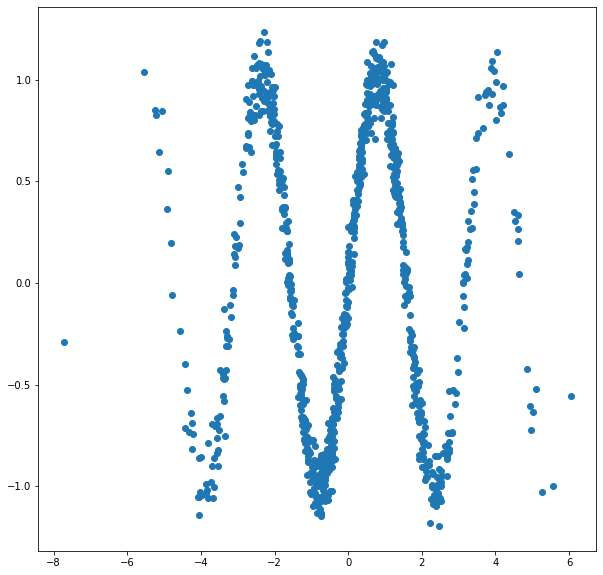

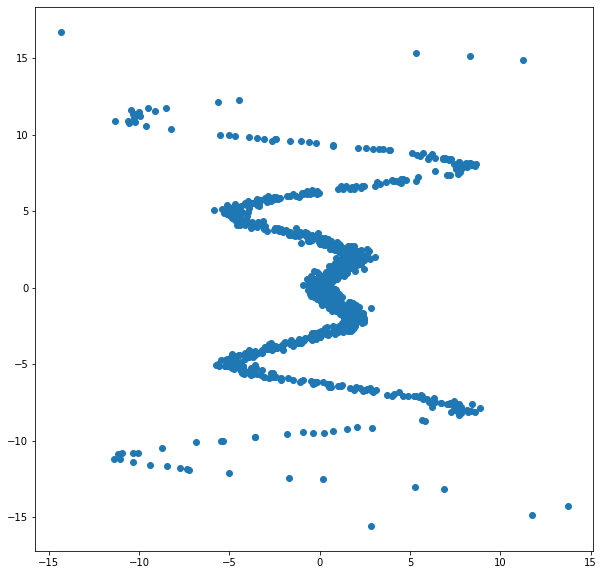

In [ ]:
f,ax = plt.subplots (figsize=(10,10))
X_RAND1 = np.random.normal(0,2,1000)
Y_RAND1 = np.sin(X_RAND1*2)+np.random.normal(0,.1,1000)
ax.scatter(X_RAND1,Y_RAND1)

f,ax = plt.subplots (figsize=(10,10))
Y_RAND2 = np.random.normal(0,5,1000)
X_RAND2 = np.power(Y_RAND2,1)*np.sin(Y_RAND2)+np.random.normal(0,.5,1000)
ax.scatter(X_RAND2,Y_RAND2)

In [ ]:
G_hv = make_generator(n_output = 2,n_input = 2, hidden_widths=[128,128])
#tf.keras.utils.plot_model(G0, "images/generator_cycle1.png")

D_hv = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128],minibatch_avg=True)
#tf.keras.utils.plot_model(D0, "images/discriminator_cycle1.png")

G_vh = make_generator(n_output = 2,n_input = 2, hidden_widths=[128,128])
#tf.keras.utils.plot_model(G0, "images/generator_cycle2.png")

D_vh = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128],minibatch_avg=True)
#tf.keras.utils.plot_model(D0, "images/discriminator_cycle2.png")



def D_hv_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D_hv(real_data),D_hv(fake_data)) + 100*discriminator_gradient_penalty_ma(real_data,fake_data,D_hv)


def G_hv_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D_hv(fake_data))+ .05*(tf.reduce_mean(tf.losses.mae(G_vh(G_hv(gen_input)[0])[0],gen_input)) + \
tf.reduce_mean(tf.losses.mae(G_hv(G_vh(real_data[0])[0])[0],real_data[0])))

def D_vh_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D_vh(real_data),D_vh(fake_data)) + 100*discriminator_gradient_penalty_ma(real_data,fake_data,D_vh)


def G_vh_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D_vh(fake_data)) + .05*tf.reduce_mean(tf.losses.mae(G_hv(G_vh(gen_input)[0])[0],gen_input) + tf.losses.mae(G_vh(G_hv(real_data[0])[0])[0],real_data[0]))

generators = {"hv" : G_hv,"vh" : G_vh}
discriminators = {"hv" : D_hv,"vh" : D_vh}
gen_objective = {"hv" : G_hv_OBJECTIVE,"vh" : G_vh_OBJECTIVE}
disc_objective = {"hv" : D_hv_OBJECTIVE,"vh" : D_vh_OBJECTIVE}

<tf.Tensor: shape=(), dtype=float32, numpy=79.27857>

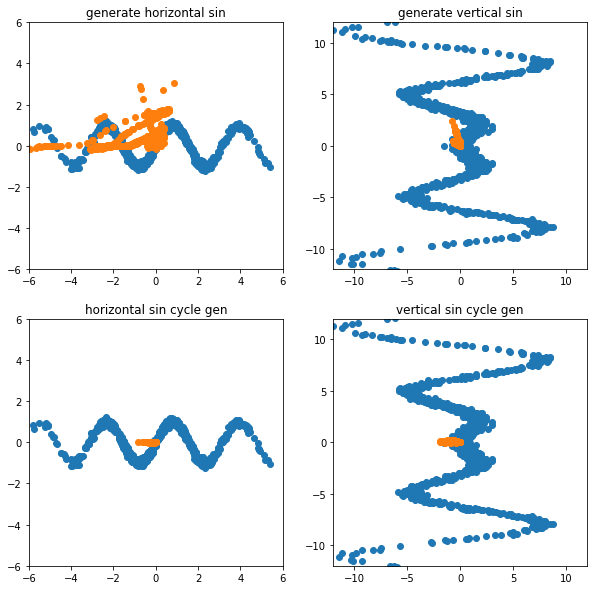

In [ ]:
f, ax = plt.subplots(2,2,figsize=(10,10))
fake_h = G_vh(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2]))
ax[0,0].scatter(X_RAND1,Y_RAND1,label="real data")
ax[0,0].scatter(fake_h[0][:,0],fake_h[0][:,1],label="from v data")
ax[0,0].set_xlim([-6,6])
ax[0,0].set_ylim([-6,6])
ax[0,0].set_title("generate horizontal sin")

fake_v = G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1]))
ax[0,1].scatter(X_RAND2,Y_RAND2,label="real data")
ax[0,1].scatter(fake_v[0][:,0],fake_v[0][:,1],label="from h data")
ax[0,1].set_xlim([-12,12])
ax[0,1].set_ylim([-12,12])
ax[0,1].set_title("generate vertical sin")

fake_hvh = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1]))[0])
ax[1,0].scatter(X_RAND1,Y_RAND1,label="real data")
ax[1,0].scatter(fake_hvh[0][:,0],fake_hvh[0][:,1],label="from cycle")
ax[1,0].set_xlim([-6,6])
ax[1,0].set_ylim([-6,6])
ax[1,0].set_title("horizontal sin cycle gen")

fake_vhv = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2]))[0])
ax[1,1].scatter(X_RAND2,Y_RAND2,label="real data")
ax[1,1].scatter(fake_vhv[0][:,0],fake_vhv[0][:,1],label="from cycle")
ax[1,1].set_xlim([-12,12])
ax[1,1].set_ylim([-12,12])
ax[1,1].set_title("vertical sin cycle gen")



G_hv_OBJECTIVE(real_data['hv'],G_hv(real_h),real_h)


D_hv_OBJECTIVE(real_data['hv'],G_hv(real_h))
#G_vh_OBJECTIVE(real_h,G_vh(real_v),real_v)

In [ ]:
real_h
#tf.reduce_mean(real_v,axis = 0)*tf.ones(shape = np.shape(real_v),dtype = "float32")
#tf.reduce_mean(r,axis = 0)
#tf.ones(shape = np.shape(r),dtype = "float32")
real_v = tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2],dtype="float32")
tf.reduce_mean(real_v,axis = 0)*tf.ones(shape = np.shape(real_v),dtype = "float32")

NameError: ignored

In [ ]:
real_data

{'hv': [<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
  array([[-0.5716202, -3.5860546],
         [ 2.1192517, -2.2971067],
         [ 1.0563003, -1.1641723],
         ...,
         [ 2.068007 , -1.9272001],
         [-3.6319706,  4.323585 ],
         [-5.2803793,  4.884454 ]], dtype=float32)>,
  <tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
  array([[-0.03742853,  0.13614956],
         [-0.03742853,  0.13614956],
         [-0.03742853,  0.13614956],
         ...,
         [-0.03742853,  0.13614956],
         [-0.03742853,  0.13614956],
         [-0.03742853,  0.13614956]], dtype=float32)>],
 'vh': [<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
  array([[ 2.3031564 , -0.9721035 ],
         [-1.0434397 , -0.98646367],
         [ 1.4055403 ,  0.3911707 ],
         ...,
         [-0.74941236, -0.84336215],
         [-0.79439944, -0.950419  ],
         [-3.5759478 , -0.6332525 ]], dtype=float32)>,
  <tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
  array([[-0.01672002, -0

In [ ]:
dhv_losses=[]
dvh_losses=[]
ghv_losses=[]
gvh_losses=[]
plt.ioff()
for i in range(20000):
    X_RAND1 = np.random.normal(0,2,1000)
    Y_RAND1 = np.sin(X_RAND1*2)+np.random.normal(0,.1,1000)
    real_h = tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1],dtype="float32")
    Y_RAND2 = np.random.normal(0,5,1000)
    X_RAND2 = np.power(Y_RAND2,1)*np.sin(Y_RAND2)+np.random.normal(0,.5,1000)
    real_v = tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2],dtype="float32")
    gen_input = {"hv" : real_h, "vh": real_v}
    real_data = {"hv": [real_v, tf.reduce_mean(real_v,axis = 0)*\
                tf.ones(shape = np.shape(real_v),dtype = "float32")],
                "vh": [real_h, tf.reduce_mean(real_h,axis = 0)*\
                tf.ones(shape = np.shape(real_h),dtype = "float32")]}
    #Step 1. Convert h to v
    #Step 2. Convert v to h
    
    train_step(generators = generators, #dictionary string -> generator
                   discriminators = discriminators, #dictionary string -> discriminator
                   real_data = real_data, #dictionary string for discriminator -> real data
                   gen_objective = gen_objective, #dictionary string -> objective function
                   disc_objective = disc_objective,
                   gen_input = gen_input,
                   gen_optimizers = {"hv" : w_generator_optimizer, "vh":w_generator_optimizer },
                   disc_optimizers = {"hv" : w_discriminator_optimizer, "vh" : w_discriminator_optimizer}, #dictionary string ->optimizer
                   gen_num_steps = {"hv":1,"vh":1},
                   disc_num_steps = {"hv":5,"vh":5}#dictionary string -> number of steps
                  )
    if i%40 == 0:
        
        dhv_losses = dhv_losses+[w_discriminator_loss(D_hv(real_data["hv"]),D_hv(G_hv(gen_input["hv"])))]
        dvh_losses = dvh_losses+[w_discriminator_loss(D_vh(real_data["vh"]),D_vh(G_vh(gen_input["vh"])))]
        ghv_losses = ghv_losses +[w_generator_loss(G_hv(gen_input["hv"]))]
        gvh_losses = gvh_losses +[w_generator_loss(G_vh(gen_input["vh"]))]

        print("disc hv loss:",w_discriminator_loss(D_hv(real_data["hv"]),D_hv(G_hv(gen_input["hv"]))))
        print("disc vh loss:",w_discriminator_loss(D_vh(real_data["vh"]),D_hv(G_vh(gen_input["vh"]))))
        print("gen vh loss:",w_generator_loss(G_vh(gen_input["vh"])))
        print("gen hv loss:",w_generator_loss(G_hv(gen_input["hv"])))
        
        f, ax = plt.subplots(2,2,figsize=(10,10))
        fake_h = G_vh(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2]))
        ax[0,0].scatter(X_RAND1,Y_RAND1,label="real data")
        ax[0,0].scatter(fake_h[0][:,0],fake_h[0][:,1],label="from v data")
        ax[0,0].set_xlim([-6,6])
        ax[0,0].set_ylim([-6,6])
        ax[0,0].set_title("generate horizontal sin")

        fake_v = G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1]))
        ax[0,1].scatter(X_RAND2,Y_RAND2,label="real data")
        ax[0,1].scatter(fake_v[0][:,0],fake_v[0][:,1],label="from h data")
        ax[0,1].set_xlim([-12,12])
        ax[0,1].set_ylim([-12,12])
        ax[0,1].set_title("generate vertical sin")

        fake_hvh = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1]))[0])
        ax[1,0].scatter(X_RAND1,Y_RAND1,label="real data")
        ax[1,0].scatter(fake_hvh[0][:,0],fake_hvh[0][:,1],label="from cycle")
        ax[1,0].set_xlim([-6,6])
        ax[1,0].set_ylim([-6,6])
        ax[1,0].set_title("horizontal sin cycle gen")

        fake_vhv = G_hv(G_vh(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2]))[0])
        ax[1,1].scatter(X_RAND2,Y_RAND2,label="real data")
        ax[1,1].scatter(fake_vhv[0][:,0],fake_vhv[0][:,1],label="from cycle")
        ax[1,1].set_xlim([-12,12])
        ax[1,1].set_ylim([-12,12])
        ax[1,1].set_title("vertical sin cycle gen")

        f.savefig("cycle"+str(i/40)+".png")

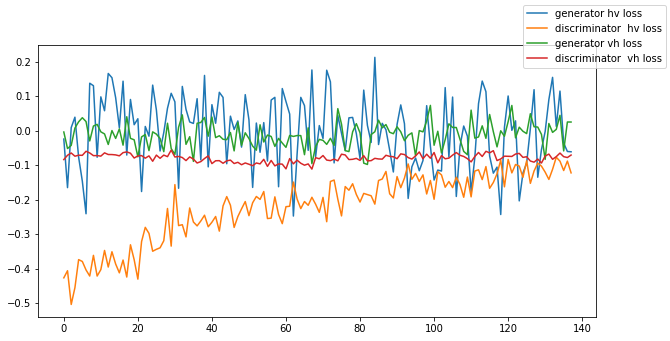

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
ax.plot(ghv_losses[30:],label="generator hv loss")
ax.plot(dhv_losses[30:],label="discriminator  hv loss")
ax.plot(gvh_losses[30:],label="generator vh loss")
ax.plot(dvh_losses[30:],label="discriminator  vh loss")

f.legend()
f.savefig("cycleloss.png")

In [ ]:
'cycle'[len('cycle')

5

In [ ]:
import imageio
import glob
anim_file="cyclegan_needs_work.gif"        
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('cycle*.png')
    filenames = sorted(filenames)
    sorted(filenames,key = \
        lambda x: int(x[5:len(x)-6]))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Challenge 3. Importance sampling GAN: Control = striped distribution. Test= Mixture of Gaussians.

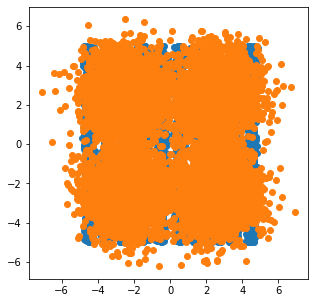

In [9]:
def generate_ctrl(N,N_stripe=6,L=-4,U=4):
    n = int(N/N_stripe)
    means = np.arange(L,U,(U-L)/N_stripe)
    means=means - np.mean(means)
    return np.vstack([np.c_[np.random.normal(x,(U-L)/(8*N_stripe),n),np.random.uniform(L,U,n)] for x in means])

def generate_treatment(N,means=[np.array((a*2.5,b*2.5)) for a in [-1,1] for b in [-1,1]],std=.5,L=-4,U=4):
    n = int(N/len(means))
    return np.vstack([np.random.multivariate_normal(x,np.eye(2)*std**2,n) for x in means])

dist1=generate_ctrl(N=10000,N_stripe=10,L=-5,U=5)
dist2=generate_treatment(N=10000,std=1.1)
plt.figure(figsize=(5,5))
plt.scatter(dist1[:,0],dist1[:,1])
plt.scatter(dist2[:,0],dist2[:,1])

In [36]:
G = make_generator(1,n_input =2, hidden_widths = [32,32,32,32], minibatch_avg=False, output_activation = tf.exp)
D = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128],minibatch_avg=False)

In [30]:
# Let's alter train step here to not disturb other code. We need discriminator loss to act on the gen_input
def train_step(generators, #dictionary string -> generator
               discriminators, #dictionary string -> discriminator
               real_data, #dictionary string for discriminator -> real data
               gen_objective, #dictionary string -> objective function
               disc_objective,
               gen_input,
               gen_optimizers,
               disc_optimizers, #dictionary string ->optimizer
               gen_num_steps,
               disc_num_steps#dictionary string -> number of steps
               ): 
    
    for gan, D in discriminators.items():
        G = generators[gan]
        real_batch = real_data[gan]
        for i in range(disc_num_steps[gan]):
            with tf.GradientTape() as D_tape:
                generated_batch = G(gen_input[gan], training = True)
                disc_obj = disc_objective[gan](real_batch, generated_batch,gen_input[gan])
            grad_D= D_tape.gradient(disc_obj, D.trainable_variables)
            disc_optimizers[gan].apply_gradients(zip(grad_D, D.trainable_variables))
        #print("discriminator objective ",disc_objective[gan](real_batch, generated_batch))
        
        for i in range(gen_num_steps[gan]):
            with tf.GradientTape() as G_tape:
                generated_batch = G(gen_input[gan], training = True)
                gen_obj = gen_objective[gan](real_batch,generated_batch,gen_input[gan])
            grad_G= G_tape.gradient(gen_obj, G.trainable_variables)
            gen_optimizers[gan].apply_gradients(zip(grad_G, G.trainable_variables))
        #print("generator objective ",gen_objective[gan](generated_batch))

In [37]:
def discriminator_gradient_penalty(real_output,fake_output,discriminator):
    batch_shape=tf.shape(real_output)
    uniform_rand = tf.random.uniform(shape=batch_shape, maxval=1)
    mask_fake = uniform_rand #tf.math.greater(.5, uniform_rand)
    mask_fake = tf.cast(mask_fake,"float32")
    mask_real = (1.-mask_fake)
    mixed_real_fake = mask_fake*fake_output[0] + mask_real*real_output
    with tf.GradientTape() as g:
        g.watch(mixed_real_fake)
        y = discriminator(mixed_real_fake)
    disc_gradient = g.gradient(y, mixed_real_fake)
    gradient_penalty = tf.reduce_mean(tf.square(
        tf.sqrt(tf.reduce_sum(tf.square(tf.concat(disc_gradient,axis=1)),axis=1))\
        - tf.ones(shape=(batch_shape[0],1))))
    return gradient_penalty
def w_i_discriminator_loss(real_output,fake_output,importance):
    real_loss = -tf.reduce_mean(real_output)    #
    weighting = importance/tf.reduce_sum(importance)

    fake_loss = tf.reduce_sum(weighting*fake_output) 
    total_loss = real_loss + fake_loss
    return total_loss
def w_i_generator_loss(fake_output, importance):
    weighting = importance/tf.reduce_sum(importance)
    return -tf.reduce_sum(weighting*fake_output) 



w_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)
w_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)

def D_OBJECTIVE(real_data,importance,gen_input):
    return w_i_discriminator_loss(D(real_data),D(gen_input),importance) + \
    10*discriminator_gradient_penalty(real_data,gen_input,D)

def G_OBJECTIVE(real_data,importance,gen_input):
    return w_i_generator_loss(D(gen_input),importance)

In [13]:

D_OBJECTIVE(dist1,G(dist2),dist2)

<tf.Tensor: shape=(), dtype=float32, numpy=9.030615>

In [ ]:
for i in range(4532,50000):
    dist1=generate_ctrl(N=5000,N_stripe=4,L=-5,U=5) #stripes
    dist2=generate_treatment(N=5000,std=1.1) #gaussians
    real_data = {"GAN0" : dist1}
    gen_input = {"GAN0": dist2}
    train_step(generators = {"GAN0" : G}, #dictionary string -> generator
                   discriminators = {"GAN0" : D}, #dictionary string -> discriminator
                   real_data = real_data, #dictionary string for discriminator -> real data
                   gen_objective = {"GAN0": G_OBJECTIVE}, #dictionary string -> objective function
                   disc_objective = {"GAN0" : D_OBJECTIVE},
                   gen_input = gen_input,
                   gen_optimizers = {"GAN0" : w_generator_optimizer},
                   disc_optimizers = {"GAN0" : w_discriminator_optimizer}, #dictionary string ->optimizer
                   gen_num_steps = {"GAN0" :1},
                   disc_num_steps = {"GAN0":20}#dictionary string -> number of steps
                  )
    
    if i%20==0:
        weights = G(dist2)/tf.reduce_sum(G(dist2))        
        print(i)
        print('Generator: ',G_OBJECTIVE(dist1,weights,dist2))
        print('Discriminator: ',D_OBJECTIVE(dist1,weights,dist2))
        f,ax = plt.subplots(figsize=(10,10))

        ax.scatter(dist1[:,0],dist1[:,1],s = 10,alpha = .1)
        ax.scatter(dist2[:,0],dist2[:,1],s=weights*1e5)

        ax.set_title('GAN importance weighting: blue - target distribution, orange - data')
        f.savefig(str(i)+'.png')

In [16]:
G(dist2)

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[1.0196588 ],
       [1.0824997 ],
       [1.1402816 ],
       ...,
       [0.90927005],
       [1.3716865 ],
       [0.73925656]], dtype=float32)>

In [39]:
i



4532